**Libraries To Import**
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay


**Date Preprocessing**
***

In [3]:
data=pd.read_csv("spam.csv",encoding='windows-1252')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
# Remove irrelevant columns 
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Rename columns
data.columns = ['label', 'message']

In [5]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#Check Missing Values 
missing_values = data.isnull().sum()
print(missing_values)

label      0
message    0
dtype: int64


In [7]:
#Check Duplicated Values 
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate records detected: {duplicate_count}")

Number of duplicate records detected: 403


In [8]:
# Remove duplicate records
data.drop_duplicates(inplace=True)

# Verify the removal of duplicates
print(f"Number of duplicate records after removal: {data.duplicated().sum()}")

Number of duplicate records after removal: 0


In [9]:
#Incoding Data (Label (spam,Ham))

label_encoder = LabelEncoder()
data['label']= label_encoder.fit_transform(data['label'])

y=data['label']

In [10]:
#Incoding Data (Message)

vectorizer = TfidfVectorizer()
x= vectorizer.fit_transform(data['message'])


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   int64 
 1   message  5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


#### Show label distribution (Spam vs Ham)


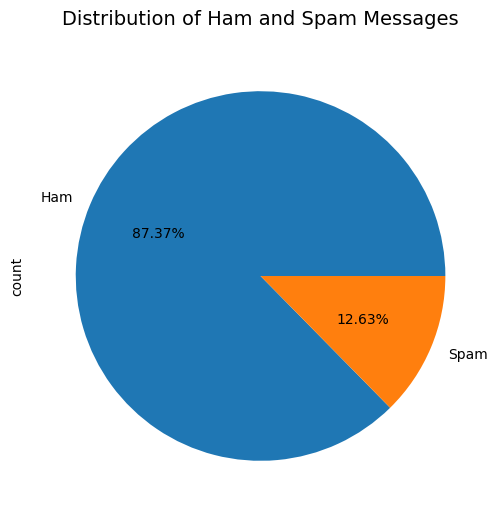

In [12]:
# Check class distribution
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(
    kind='pie', 
    labels=['Ham', 'Spam'], 
    autopct='%0.2f%%', 
                             )

plt.title('Distribution of Ham and Spam Messages', fontsize=14, pad=15)

plt.show()

In [13]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# ------------------------------
# Base Model section (Decision Tree)
# ------------------------------

In [33]:

base_model = DecisionTreeClassifier(random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)


Accuracy: 0.9642166344294004

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       889
           1       0.88      0.86      0.87       145

    accuracy                           0.96      1034
   macro avg       0.93      0.92      0.93      1034
weighted avg       0.96      0.96      0.96      1034



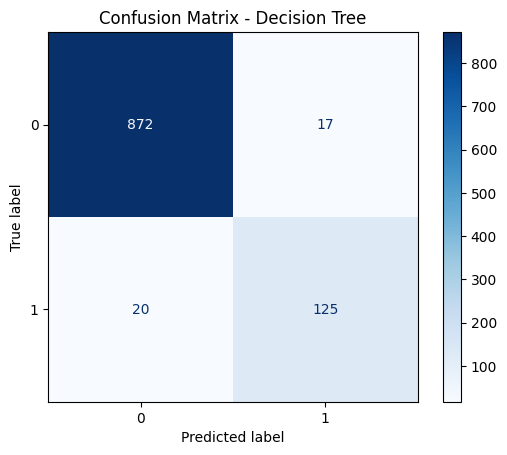

In [34]:
# Compute Accuracyy
acc_base = accuracy_score(y_test, y_pred_base)
print("Accuracy:",acc_base )

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_base))

ConfusionMatrixDisplay.from_estimator(base_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

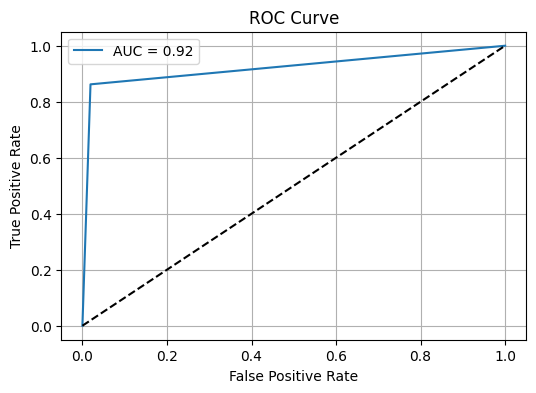

In [35]:
# ROC Curve
y_proba = base_model.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
auc_base = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Stacking Classifier Section
# ------------------------------


In [16]:
# Define base models for stacking
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),  # Decision Tree
    ('knn', KNeighborsClassifier(n_neighbors=5)),                 # KNN
    ('svm', SVC(probability=True, kernel='linear', random_state=42))  # SVM
]

# Define the meta-learner (final model)
meta_learner = LogisticRegression()

# Create the Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,  # Base models
    final_estimator=meta_learner,  # Meta model
    passthrough=False,  # Use original features + predictions from base models
    cv=5  # Cross-validation
)

# Train the Stacking model on the training data
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('svm',
                                SVC(kernel='linear', probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression())

Accuracy: 0.9874274661508704

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       889
           1       0.98      0.93      0.95       145

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



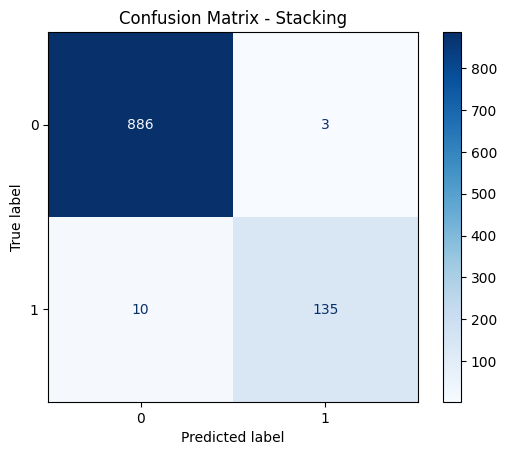

In [17]:
# Make predictions on the test set
y_pred_stacking = stacking_model.predict(X_test)

acc_stacking = accuracy_score(y_test, y_pred_stacking)
print("Accuracy:", acc_stacking)

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_stacking))

ConfusionMatrixDisplay.from_estimator(stacking_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Stacking")
plt.show()

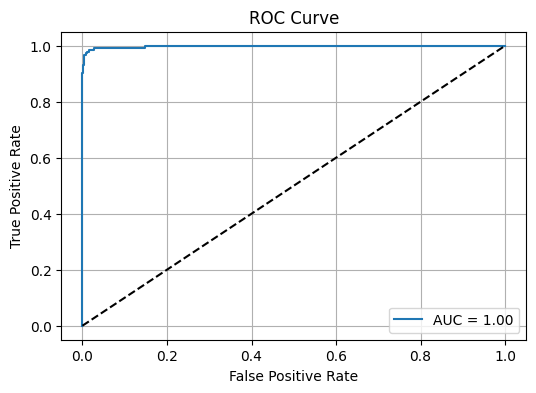

In [18]:
# ROC Curve
y_proba = stacking_model.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
auc_stacking = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
#  boosting Classifier Section
# ------------------------------


In [19]:

# Create XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage (controls impact of each tree)
    max_depth=3,        # Maximum depth of each tree
    random_state=42,
    eval_metric="mlogloss"  # Multi-class log loss
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)


Accuracy: 0.965183752417795

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       889
           1       0.96      0.79      0.86       145

    accuracy                           0.97      1034
   macro avg       0.96      0.89      0.92      1034
weighted avg       0.96      0.97      0.96      1034



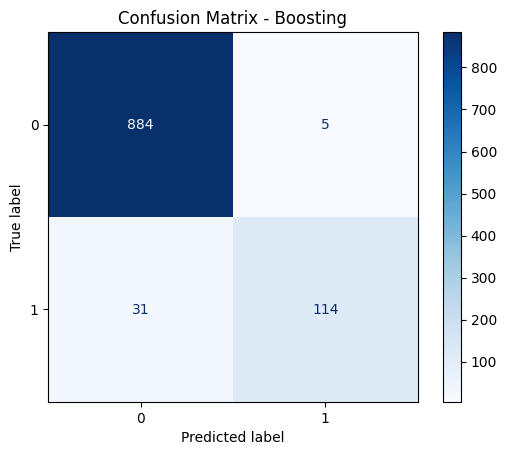

In [20]:
# Accuracy
acc_boosting= accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", acc_boosting)

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Boosting")
plt.show()

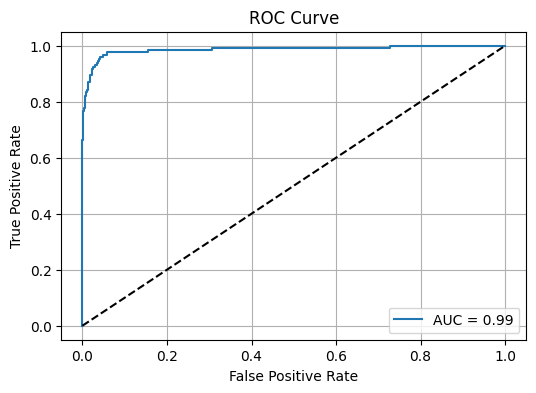

In [21]:
y_proba = xgb_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
auc_boosting= auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
#  Bagging Classifier Section
# ------------------------------


In [22]:
# Create a Bagging model using Decision Tree
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model (Decision Tree)
    n_estimators=10,  # Number of estimators (trees)
    max_samples=0.8,  # Percentage of data used per model
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    random_state=42
)

In [23]:
# Train the Bagging model on the training data
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  random_state=42)

Accuracy: 0.97678916827853

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.96      0.87      0.91       145

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



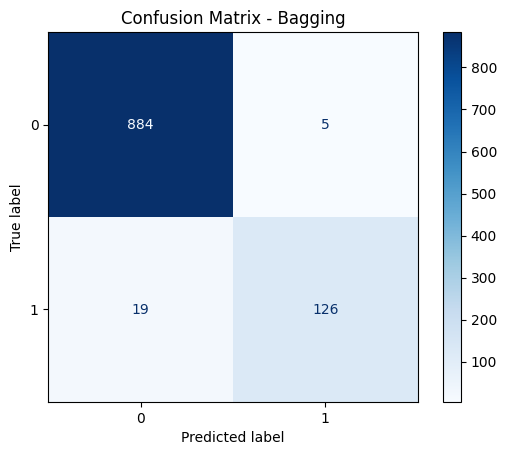

In [24]:
# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Compute Accuracy
acc_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy:", acc_bagging)

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_bagging))

ConfusionMatrixDisplay.from_estimator(bagging_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Bagging")
plt.show()

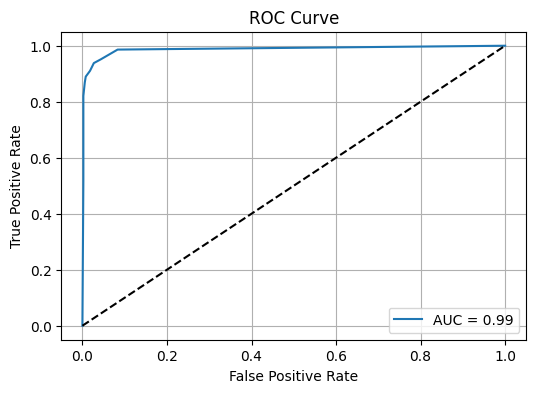

In [25]:
# ROC Curve
y_proba = bagging_model.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
auc_bagging = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


#  Final Comparison Between Models



C:\Users\ELGENDY\AppData\Local\Temp\ipykernel_10444\26276432.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies,palette=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])


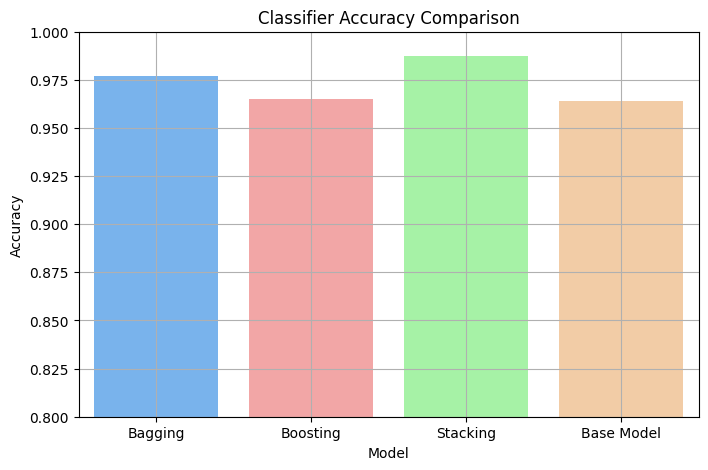

In [26]:
# Performance comparison
models = ['Bagging', 'Boosting', 'Stacking', 'Base Model']
accuracies = [acc_bagging, acc_boosting, acc_stacking, base_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies,palette=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.ylim(0.8, 1.0)
plt.title("Classifier Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.grid(True)
plt.show()


C:\Users\ELGENDY\AppData\Local\Temp\ipykernel_10444\2855610771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=aucs, palette=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])


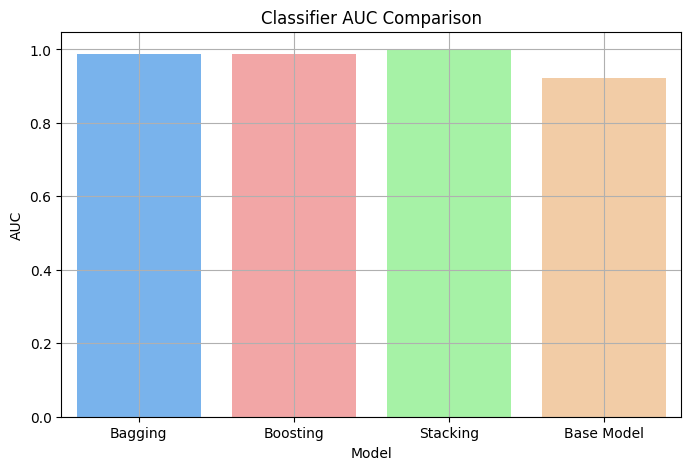

In [36]:
aucs = [auc_bagging, auc_boosting, auc_stacking, auc_base]
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=aucs, palette=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.title("Classifier AUC Comparison")
plt.ylabel("AUC")
plt.xlabel("Model")
plt.grid(True)
plt.show()
